Based on the paper:
Paul Hoffman, Matthew A. Lambon Ralph, and Timothy T. Rogers, “Semantic Diversity: A Measure of Semantic Ambiguity Based on Variability in the Contextual Usage of Words,” Behavior Research Methods 45, no. 3 (September 1, 2013): 718–30, https://doi.org/10.3758/s13428-012-0278-x.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize

In [2]:
def perform_lsa(corpus, context_length=1000):
    """
    Perform latent semantic analysis on the given corpus.
    
    Args:
        corpus (list of lists): The corpus of text, where each inner list represents a context.
        context_length (int): The length of each context in words. Default is 1,000.
    
    Returns:
        word_vectors (dict): A dictionary mapping words to their 300-dimensional LSA vectors.
        context_vectors (list): A list of 300-dimensional LSA vectors, one for each context.
    """
    # Create the co-occurrence matrix
    word_to_index = {}
    index_to_word = []
    co_occurrence_matrix = []
    current_context = []
    for word in corpus:
        current_context.append(word)
        if len(current_context) == context_length:
            context_vector = [0] * len(set(corpus))
            for w in current_context:
                if w not in word_to_index:
                    word_to_index[w] = len(index_to_word)
                    index_to_word.append(w)
                word_index = word_to_index[w]
                context_vector[word_index] += 1
            co_occurrence_matrix.append(context_vector)
            current_context = []
    if current_context:
        context_vector = [0] * len(set(corpus))
        for w in current_context:
            if w not in word_to_index:
                word_to_index[w] = len(index_to_word)
                index_to_word.append(w)
            word_index = word_to_index[w]
            context_vector[word_index] += 1
        co_occurrence_matrix.append(context_vector)
    co_occurrence_matrix = np.array(co_occurrence_matrix)
    
    # Apply log transformation and entropy weighting
    co_occurrence_matrix = np.log(co_occurrence_matrix + 1)
    word_entropies = np.sum(-co_occurrence_matrix * np.log(co_occurrence_matrix), axis=0)
    co_occurrence_matrix = np.divide(co_occurrence_matrix, word_entropies)
    co_occurrence_matrix = np.nan_to_num(co_occurrence_matrix)
    
    # Perform singular value decomposition
    u, s, vt = np.linalg.svd(co_occurrence_matrix, full_matrices=False)
    word_vectors = {word: u[i, :300] for i, word in enumerate(index_to_word)} # 300 dimensions is supposedly optimal according to the article.
    context_vectors = vt[:300, :]
    
    return word_vectors, context_vectors

def calculate_semd(word, word_vectors, context_vectors):
    """
    Calculate the semantic diversity (SemD) of the given word.
    
    Args:
        word (str): The word for which to calculate SemD.
        word_vectors (dict): A dictionary mapping words to their 300-dimensional LSA vectors.
        context_vectors (list): A list of 300-dimensional LSA vectors, one for each context.
    
    Returns:
        semd (float): The semantic diversity value for the word.
    """
    # Find all contexts containing the word
    word_contexts = [i for i in context_vectors if word in word_vectors]
    # if len(word_contexts) > 2000:
    #     word_contexts = np.random.choice(word_contexts, size=2000, replace=False)

    # Calculate the average cosine similarity between the contexts
    context_similarities = [1 - cosine(word_contexts[i], word_contexts[j]) for i in range(len(word_contexts)) for j in range(len(word_contexts)) if i < j]
    mean_similarity = np.mean(context_similarities)

    # Calculate the SemD value
    semd = -np.log(mean_similarity)
    
    return semd

In [26]:
corpus = []

directory = '../Text data/'
for file in os.listdir(directory):
    if file.endswith('.txt'):
        with open(os.path.join(directory, file), 'r') as f:
            content = f.read().replace('\n', ' ')
            corpus.extend(content.split())


len(corpus)

962134

In [71]:
current_context = []
context_length = 1000
word_to_index = {}
index_to_word = []
co_occurrence_matrix = []
# co_occurrence_matrix = np.zeros((len(set(corpus)), len(set(corpus))))
# Split corpus into contexts of length context_length
current_context = []
contexts = []

for word in corpus:
    current_context.append(word)
    if len(current_context) == context_length:
        contexts.append(current_context)
        current_context = []

if current_context:
    contexts.append(current_context)


# for word in corpus:
#     current_context.append(word)
#     if len(current_context) == context_length:
#         context_vector = [0] * len(set(corpus))
#         for w in current_context:
#             if w not in word_to_index:
#                 word_to_index[w] = len(index_to_word)
#                 index_to_word.append(w)
#             word_index = word_to_index[w]
#             context_vector[word_index] += 1
#         contexts.append(current_context)
#         co_occurrence_matrix.append(context_vector)
#         current_context = []
# if current_context:
#         context_vector = [0] * len(set(corpus))
#         for w in current_context:
#             if w not in word_to_index:
#                 word_to_index[w] = len(index_to_word)
#                 index_to_word.append(w)
#             word_index = word_to_index[w]
#             context_vector[word_index] += 1
#         co_occurrence_matrix.append(context_vector)
# co_occurrence_matrix = np.array(co_occurrence_matrix)
# co_occurrence_matrix[0]
# # Apply log transformation and entropy weighting
# co_occurrence_matrix = np.log(co_occurrence_matrix + 1)
# word_entropies = np.sum(-co_occurrence_matrix * np.log(co_occurrence_matrix), axis=0)
# co_occurrence_matrix = np.divide(co_occurrence_matrix, word_entropies)
# co_occurrence_matrix = np.nan_to_num(co_occurrence_matrix)

# for context in co_occurrence_matrix:
    
#     # Perform singular value decomposition
#     u[context], s[context], vt[context] = np.linalg.svd(co_occurrence_matrix, full_matrices=False)

#     word_vectors = {word: u[i, :300] for i, word in enumerate(index_to_word)} # 300 dimensions is supposedly optimal according to the article.


1000

In [32]:
# Perform latent semantic analysis (LSA) on the contexts
# This will give us word vectors and context vectors
word_vectors, context_vectors = perform_lsa(corpus, context_length=1000)
word_vectors

C:\Users\Srikanth\AppData\Local\Temp\ipykernel_4400\3434460936.py:43: RuntimeWarning: divide by zero encountered in log
  word_entropies = np.sum(-co_occurrence_matrix * np.log(co_occurrence_matrix), axis=0)
C:\Users\Srikanth\AppData\Local\Temp\ipykernel_4400\3434460936.py:43: RuntimeWarning: invalid value encountered in multiply
  word_entropies = np.sum(-co_occurrence_matrix * np.log(co_occurrence_matrix), axis=0)


IndexError: index 22 is out of bounds for axis 0 with size 22

In [13]:
word = 'man'
word_contexts = [i for i in context_vectors if word in word_vectors]
# if len(word_contexts) > 2000:
#     word_contexts = np.random.choice(word_contexts, size=2000, replace=False)

# Calculate the average cosine similarity between the contexts
context_similarities = [1 - cosine(word_contexts[i], word_contexts[j]) for i in range(len(word_contexts)) for j in range(len(word_contexts)) if i < j]
mean_similarity = np.mean(context_similarities)

# Calculate the SemD value
semd = -np.log(mean_similarity)
context_similarities

[]

In [14]:
corpus

'A Midsummer Night\'s Dreamby William ShakespeareEdited by Barbara A. Mowat and Paul Werstine  with Michael Poston and Rebecca NilesFolger Shakespeare Libraryhttps://shakespeare.folger.edu/shakespeares-works/a-midsummer-nights-dream/Created on Jul 31, 2015, from FDT version 0.9.2Characters in the Play======================Four lovers:  HERMIA  LYSANDER  HELENA  DEMETRIUSTHESEUS, duke of AthensHIPPOLYTA, queen of the AmazonsEGEUS, father to HermiaPHILOSTRATE, master of the revels to TheseusNICK BOTTOM, weaverPETER QUINCE, carpenterFRANCIS FLUTE, bellows-menderTOM SNOUT, tinkerSNUG, joinerROBIN STARVELING, tailorOBERON, king of the FairiesTITANIA, queen of the FairiesROBIN GOODFELLOW, a "puck," or hobgoblin, in Oberon\'s serviceA FAIRY, in the service of TitaniaFairies attending upon Titania:  PEASEBLOSSOM  COBWEB  MOTE  MUSTARDSEEDLords and Attendants on Theseus and HippolytaOther Fairies in the trains of Titania and OberonACT 1=====Scene 1=======[Enter Theseus, Hippolyta, and Philostra

In [15]:

# Calculate semantic diversity (SemD) for each word
semd_values = []

for word in set(corpus):
    semd_value = calculate_semd(word, word_vectors, context_vectors)
    semd_values.append(semd_value)


NameError: name 'cosine' is not defined

In [114]:
len(semd_values)

74

In [115]:
# semd_values = [0 if np.isnan(x) else x for x in semd_values]
semd_values

[40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,
 40.46379065357408,


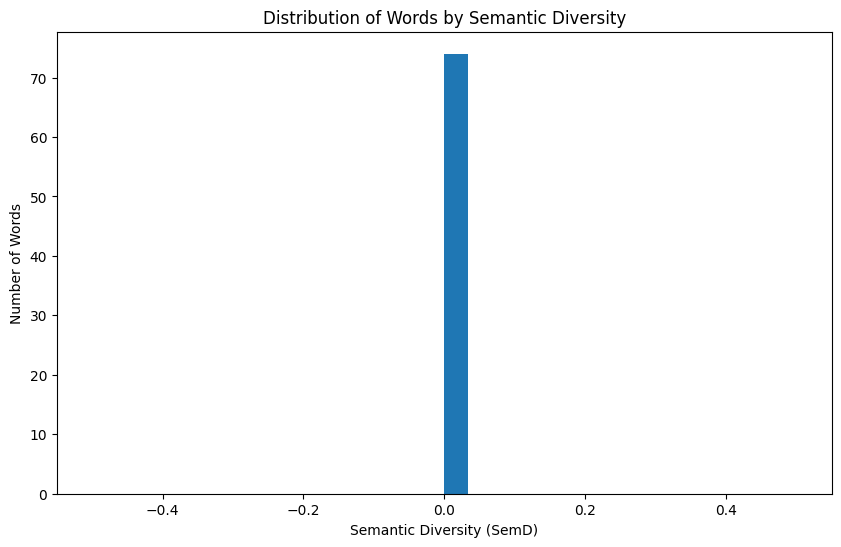

In [77]:

# Plot the distribution of words as a function of semantic diversity
plt.figure(figsize=(10, 6))
plt.hist(semd_values, bins=30)
plt.xlabel('Semantic Diversity (SemD)')
plt.ylabel('Number of Words')
plt.title('Distribution of Words by Semantic Diversity')
plt.show()